In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv("data/combined_data.csv", low_memory=False)

labelEncodedFeatures = []
for feature in df.columns:
    if feature.endswith("_le"):
        labelEncodedFeatures.append(feature)

for feature in labelEncodedFeatures:
    df[feature] = pd.to_numeric(df[feature], errors="coerce")

featureLabels = {
    'occupation_le': 'Occupation',
    'industry_le': 'Industry',
    'employment_type_le': 'Employment Type',
    'carlicence_le': 'Car License',
    'homesubregion_ASGS_le': 'Home Subregion',
    'agegroup_le': 'Age Group (Binned)',
    'owndwell_le': 'Ownership Status',
    'sex_le': 'Sex',
    'persinc_bin_le': 'Personal Income (Binned)',
    'hhinc_bin_le': 'Household Income (Binned)',
    'totalvehs_bin_le': 'Total Vehicles (Binned)',
}

features = list(featureLabels.keys())
target = "wfh_freq_le"

for feature in features + [target]:
    df[feature] = pd.to_numeric(df[feature], errors="coerce").astype(int)


In [10]:
def calculateEntropy(feature):
    probabilities = feature.value_counts(normalize=True)
    entropy = -sum(probabilities * np.log2(probabilities))
    return entropy

In [11]:
def calculateConditionalEntropy(feature, target):
    temp_df = pd.DataFrame({'X': feature, 'Y': target})
    probability_x = feature.value_counts(normalize=True)
    entropy_by_group = temp_df.groupby('X')['Y'].aggregate(calculateEntropy)
    conditional_entropy = sum(probability_x * entropy_by_group)
    return conditional_entropy

In [12]:
def calculateNMI(feature, target):
    entropy_x = calculateEntropy(feature)
    entropy_y = calculateEntropy(target)
    conditional_entropy = calculateConditionalEntropy(feature, target)
    MI = entropy_y - conditional_entropy
    return MI / min(entropy_x, entropy_y)

In [13]:
nmiResults = {}
print("Normalised Mutual Information (Feature : Score)")
for feature in features:
    nmiResults[featureLabels[feature]] = calculateNMI(df[feature], df[target])
    print(featureLabels[feature], ":", round(nmiResults[featureLabels[feature]], 5))


Normalised Mutual Information (Feature : Score)
Occupation : 0.09213
Industry : 0.05607
Employment Type : 0.03379
Car License : 0.01189
Home Subregion : 0.03068
Age Group (Binned) : 0.02753
Ownership Status : 0.00423
Sex : 0.00063
Personal Income (Binned) : 0.05001
Household Income (Binned) : 0.01474
Total Vehicles (Binned) : 0.01195


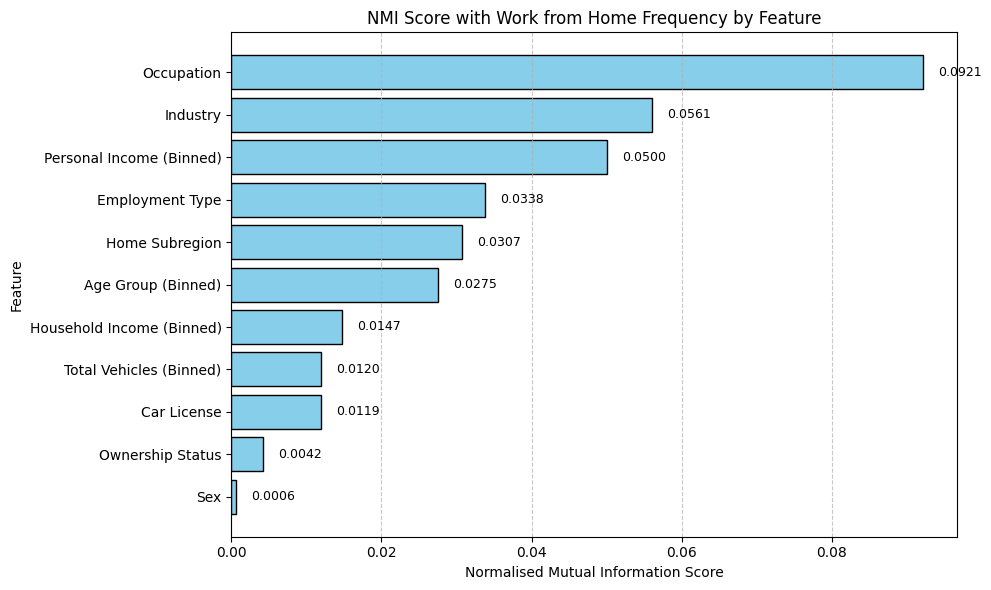

In [14]:
# Sort features by NMI score
sorted_features = sorted(nmiResults.items(), key=lambda x: x[1], reverse=True)
features_names = [item[0] for item in sorted_features]
scores = [item[1] for item in sorted_features]

plt.figure(figsize=(10, 6))
plt.barh(features_names, scores, color='skyblue', edgecolor='black')
plt.gca().invert_yaxis()  # highest NMI on top

# Labels and title
plt.xlabel("Normalised Mutual Information Score")
plt.ylabel("Feature")
plt.title("NMI Score with Work from Home Frequency by Feature")

# Add value labels next to each bar
for i, (name, score) in enumerate(zip(features_names, scores)):
    plt.text(score + 0.002, i, f'{score:.4f}', va='center', fontsize=9)

# Minimal styling
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/nmi_scores.png", dpi=300)
plt.show()
plt.close()